<a href="https://colab.research.google.com/github/bachaudhry/kaggle_birdCLEF_25/blob/main/BirdCLEF25_03_Baseline_Precomputed_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, gc, random, math, time, copy , zipfile, tarfile, shutil, subprocess, json
from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import librosa
import librosa.display
import soundfile as sf

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import LabelEncoder

In [4]:
sys.path.append('/content/drive/MyDrive/Kaggle/Bird_CLEF25/utils')
from utils import Config, BirdClefDataset, create_target_tensor, seed_everything, process_gzipped

In [5]:
cfg = Config()
# Path to original train.csv, audio and metadata
cfg.BASE_DATA_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/birdclef-2025")
# Path to npy files
cfg.PRECOMPUTED_SPECS_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/precomputed-specs-np-zipped")
# Path to local specs
#cfg.LOCAL_SPECS_PATH = Path("/content/precomputed_spectrograms")
# Training meta data
cfg.TRAIN_METADATA_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/birdclef-2025/train.csv")

In [6]:
# --- Set Device & Seed ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
seed_everything(cfg.SEED)

Using device: cuda
Seeded everything with: 42


In [7]:
if cfg.NUM_WORKERS > 0:
    try:
        current_context = mp.get_context(None)
        if not isinstance(current_context, mp.SpawnContext):
             mp.set_start_method('spawn', force=True)
             print("Set multiprocessing start method to 'spawn'.")
        else:
             print("Multiprocessing start method already set to 'spawn'.")
    except RuntimeError as e:
        print(f"Could not set start method (might be already set or first run): {e}")

Set multiprocessing start method to 'spawn'.


In [8]:
# --- Load Metadata ---
if not cfg.TRAIN_METADATA_PATH.exists():
    print(f"ERROR: Metadata file not found at {cfg.TRAIN_METADATA_PATH}")
    # Stop execution or handle
else:
    train_df = pd.read_csv(cfg.TRAIN_METADATA_PATH)
    print(f"Train metadata loaded. Shape: {train_df.shape}")

Train metadata loaded. Shape: (28564, 13)


In [9]:
#import gdown
## Testing improved download and unzip function
#def process_gzippedV2(input_path, output_path=None):
#  local_temp_dir = "/content/temp_data"
  #local_extract_path = os.path.join(local_temp_dir, "extracted")
 # os.makedirs(local_extract_path, exist_ok=True)
  #os.makedirs(local_temp_dir, exist_ok=True)

  # Download using gdown - timeout issues
  #print("Downloading compressed file from Google Drive...")
  #url = f'https://drive.google.com/uc?id={file_id.split("/")[-2]}'
  #compressed_path = gdown.download(url, output=local_temp_dir, quiet=False)
  # Ensure compressed_path is a file, not the directory
  #compressed_path = os.path.join(local_temp_dir, compressed_path)  # Corrected line

    # Get filename and local paths
  #filename = os.path.basename(input_path)
  #local_compressed_path = os.path.join(local_temp_dir, filename)
  #local_extract_path = os.path.join(local_temp_dir, 'extracted')
  #os.makedirs(local_extract_path, exist_ok=True)

  # Download file from Drive to Colab
  #print(f"Copying {filename} from Drive to Colab...")
  #drive_path = os.path.join('/content/drive/MyDrive/', input_path)
  #shutil.copy2(drive_path, local_compressed_path) # Slower but more robust

  # Extract with parallel decompression (if possible/available)
  #print(f"Extracting {os.path.basename(local_compressed_path)}...")
  #try:
    # Using pigz for parallel decompression
    #subprocess.run(['pigz', '--version'], check=True)
    #subprocess.run(['tar', '-I', 'pigz', '-xf', local_compressed_path, '-C', local_extract_path],
    #               check=True)
  #except:
    # Fallback to tar
    #subprocess.run(['tar', '-xzf', local_compressed_path, '-C', local_extract_path],
    #               check=True)

  # Clean up compressed file
  #os.remove(local_compressed_path)

  # Optional upload to drive
  #if output_path:
       #print("⏫ Starting Drive upload...")
        #drive_output_path = os.path.join('/content/drive/MyDrive', output_path)

        # Use parallel upload with rsync
        #subprocess.run([
            #'rsync', '-a', '--info=progress2',
            #local_extract_path + '/',
            #drive_output_path
        #], check=True)

  #print("✅ All operations completed!")
  #return local_extract_path


In [10]:
#file_id = 'https://drive.google.com/file/d/1Ji5acgpHlyyhd8vI8gyQlN1nkjh16MwN/view?usp=drive_link'
#input_path= "/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/precomputed-specs-np-zipped"
#ocal_extract = process_gzippedV2(input_path)

In [11]:
# Download zipped folder and extract to local # One time per setup
#input_path = "/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/precomputed-specs-np-zipped"
#local_extract = process_gzipped(input_path)

In [12]:
# Update precomputed specs path
#cfg.PRECOMPUTED_SPECS_PATH = cfg.LOCAL_SPECS_PATH
# Run check
local_specs_path = Path("/content/temp_data/extracted/kaggle/working/precomputed_specs_np")
all_precomputed_files = list(local_specs_path.glob("*.npy"))
print(f"Found {len(all_precomputed_files)} precomputed .npy files.")

Found 187904 precomputed .npy files.


In [13]:
cfg.PRECOMPUTED_SPECS_PATH = local_specs_path

In [14]:
# Create label mappings
unique_labels = sorted(train_df['primary_label'].unique())
cfg.NUM_CLASSES = len(unique_labels)
cfg.LABEL_TO_INT = {label: i for i, label in enumerate(unique_labels)}
cfg.INT_TO_LABEL = {i: label for label, i in cfg.LABEL_TO_INT.items()}
train_df['primary_label_int'] = train_df['primary_label'].map(cfg.LABEL_TO_INT)
print(f"{cfg.NUM_CLASSES} unique classes found.")

206 unique classes found.




---



This next step involves the creation of a manifest file to make the process of ensuring that preprocessed spectrograms are mapped to their respective originals in the train DF metadata file.

If done correctly this cell will only need to be run once so that a `manifest.csv` file is created and stored in Google Drive. Afterwards, this step can be commented out and will be replaced with a new cell to simply load the manifest file from source.



---



In [15]:
# --- CREATE MANIFEST REVISED  ---

# --- Load Metadata ---
#if not cfg.TRAIN_METADATA_PATH.exists():
#    print(f"ERROR: Metadata file not found at {cfg.TRAIN_METADATA_PATH}")
#    raise FileNotFoundError(f"Metadata missing: {cfg.TRAIN_METADATA_PATH}")

#train_df = pd.read_csv(cfg.TRAIN_METADATA_PATH)
#print(f"Train metadata loaded. Shape: {train_df.shape}")

# --- Create Label Mappings ---
#unique_labels = sorted(train_df['primary_label'].unique())
#cfg.NUM_CLASSES = len(unique_labels)
#cfg.LABEL_TO_INT = {label: i for i, label in enumerate(unique_labels)}
#cfg.INT_TO_LABEL = {i: label for label, i in cfg.LABEL_TO_INT.items()}
#train_df['primary_label_int'] = train_df['primary_label'].map(cfg.LABEL_TO_INT)
#print(f"{cfg.NUM_CLASSES} unique classes found.")

# --- Scan Precomputed Files and Create clip_samples & Manifest ---
#all_precomputed_files = list(cfg.PRECOMPUTED_SPECS_PATH.glob("*.npy"))
#print(f"Found {len(all_precomputed_files)} precomputed .npy files.")

#clip_samples = []
#manifest_data = []

#if not all_precomputed_files:
#    print("ERROR: No precomputed files found.")
#else:
#    print("Generating clip_info_list and manifest from precomputed files and train_df...")

    # --- Create the lookup dictionary ---
    # Key: The part of the .npy filename BEFORE "_clipIDX"
    # Value: (primary_label_int, original_filename_from_train_df)
#    filename_to_label_map = {}
#    for _, row in train_df.iterrows():
#        original_filename_from_train_df = row['filename']
        # THIS IS THE KEY ASSUMPTION:
        # The key should be the original filename as it appears in train_df,
        # if your .npy files are like "TRAIN_DF_FILENAME_clipIDX.npy"
        # If train_df filenames have '/', and .npy files have them replaced with '_', adjust here.
        # For now, assume .npy naming directly uses train_df['filename'] (potentially with slashes replaced)

        # Let's assume your .npy files look like: "original_filename_from_train_df_WITH_SLASHES_REPLACED_clipIDX.npy"
        # AND that ".ogg" is part of this stem in the .npy file.
#        key_for_map = original_filename_from_train_df.replace('/', '_') # Example: "subdir_file.ogg"

#        filename_to_label_map[key_for_map] = (row['primary_label_int'], original_filename_from_train_df)

    # --- DEBUG: Print some keys from the map ---
 #   print(f"Generated {len(filename_to_label_map)} keys for lookup map.")
 #   print("Sample keys from filename_to_label_map (first 5):")
 #   for i, key in enumerate(filename_to_label_map.keys()):
 #       if i < 5:
 #           print(f"  '{key}' -> {filename_to_label_map[key]}")
 #       else:
 #           break
    # --- END DEBUG ---

 #   processed_count = 0
 #   for spec_path in tqdm(all_precomputed_files, desc="Mapping precomputed files"):
 #       try:
 #           npy_filename_stem_full = spec_path.stem # e.g., "21211_XC934741.ogg_clip0"
 #           parts = npy_filename_stem_full.rsplit('_clip', 1) # Use rsplit to split on the *last* occurrence

 #           if len(parts) != 2:
 #               print(f"Warning: Could not parse clip index from '{spec_path.name}' using '_clip'. Skipping. Full stem: '{npy_filename_stem_full}'")
 #               continue

 #           parsed_name_stem_from_npy = parts[0] # This should be the key we look up, e.g., "21211_XC934741.ogg"
                                                # or "ebird_code_XC12345.ogg"

            # --- DEBUG: Print parsed stem from .npy ---
 #           if processed_count < 5: # Print for the first 5 .npy files
 #                print(f"  Attempting to match .npy parsed stem: '{parsed_name_stem_from_npy}'")
            # --- END DEBUG ---

 #           clip_idx_str = parts[1]
 #           if not clip_idx_str.isdigit():
 #               print(f"Warning: Clip index part '{clip_idx_str}' is not a digit in '{spec_path.name}'. Skipping.")
 #               continue
 #           clip_idx = int(clip_idx_str)


#            if parsed_name_stem_from_npy in filename_to_label_map:
#                primary_label_int, original_full_filename = filename_to_label_map[parsed_name_stem_from_npy]

#                clip_entry = {
#                    'original_filename': original_full_filename,
#                    'spec_npy_filename': spec_path.name,
#                    'clip_index': clip_idx,
#                    'primary_label_int': primary_label_int
#                }
#                clip_samples.append(clip_entry)
#                manifest_data.append(clip_entry)
#            else:
#                if processed_count < 20: # Print warning only for the first few mismatches to avoid flooding
#                    print(f"Warning: No match in train_df lookup for parsed .npy stem '{parsed_name_stem_from_npy}' from file '{spec_path.name}'")

#            processed_count += 1

#        except Exception as e:
#            print(f"Error parsing or mapping {spec_path.name}: {e}")

#    cfg.TOTAL_CLIPS = len(clip_samples)
#    print(f"Created {cfg.TOTAL_CLIPS} clip samples from precomputed files.")

#    if not clip_samples:
#         print("CRITICAL ERROR: clip_samples list is empty. Check mapping logic and .npy filenames based on debug output.")
#    else:
#        manifest_df = pd.DataFrame(manifest_data)
#        manifest_save_path = "/content/temp_data/manifest.csv"
#        try:
#            manifest_df.to_csv(manifest_save_path, index=False)
#            print(f"Manifest file saved to: {manifest_save_path}")
#            print(manifest_df.head())
#        except Exception as e:
#            print(f"Error saving manifest to {manifest_save_path}: {e}")
#            print("Attempting to save to /content/manifest.csv instead...")
#            manifest_save_path_content = Path("/content/manifest.csv")
#            manifest_df.to_csv(manifest_save_path_content, index=False)
#            print(f"Manifest file saved to: {manifest_save_path_content}")
#            print(manifest_df.head())



In [16]:
# Load manifest data
manifest_load_path = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/manifest.csv")
if manifest_load_path.exists():
    manifest_df = pd.read_csv(manifest_load_path)
    print(f"Manifest loaded from {manifest_load_path}")
    print(manifest_df.head(15))

    # Ensure correct data types
    manifest_df['clip_index'] = manifest_df['clip_index'].astype(int)
    manifest_df['primary_label_int'] = manifest_df['primary_label_int'].astype(int)

    clip_samples = manifest_df.to_dict('records') # Convert DF rows to list of dicts
    cfg.TOTAL_CLIPS = len(clip_samples)
    print(f"Loaded {cfg.TOTAL_CLIPS} clip samples from mainfest.")
    print("Sample loaded clip_info: ", clip_samples[0] if clip_samples else "N/A")
else:
  print(f"Error: Manifest not found at {manifest_load_path}")
  raise FileNotFoundError(f"Manifest missing: {manifest_load_path}")

Manifest loaded from /content/drive/MyDrive/Kaggle/Bird_CLEF25/data/manifest.csv
          original_filename                  spec_npy_filename  clip_index  \
0       strowl1/XC48736.ogg      strowl1_XC48736.ogg_clip1.npy           1   
1       roahaw/XC113755.ogg      roahaw_XC113755.ogg_clip1.npy           1   
2       bkcdon/XC250791.ogg      bkcdon_XC250791.ogg_clip2.npy           2   
3      bkmtou1/XC821017.ogg    bkmtou1_XC821017.ogg_clip17.npy          17   
4      yebsee1/XC216248.ogg    yebsee1_XC216248.ogg_clip11.npy          11   
5       roahaw/XC925789.ogg     roahaw_XC925789.ogg_clip16.npy          16   
6   grbhaw1/iNat1156713.ogg  grbhaw1_iNat1156713.ogg_clip0.npy           0   
7       grnkin/XC452703.ogg      grnkin_XC452703.ogg_clip1.npy           1   
8      paltan1/XC375634.ogg    paltan1_XC375634.ogg_clip27.npy          27   
9      cotfly1/XC817211.ogg     cotfly1_XC817211.ogg_clip2.npy           2   
10     wbwwre1/XC456410.ogg     wbwwre1_XC456410.ogg_clip0.np

## Training / Validation Split

In [17]:
if 'clip_samples' not in globals() or not clip_samples:
  print("Error: clip_samples is not loaded, run the previous steps first!")
  raise ValueError("clip_samples not loaded. Can't proceed with data splitting.")
else:
  clip_df_for_split = pd.DataFrame(clip_samples)

  # Filter classes with only one sample - for stratification
  label_counts = clip_df_for_split['primary_label_int'].value_counts()
  single_sample_labels = label_counts[label_counts == 1].index.tolist()

  if single_sample_labels:
    print(f"Found {len(single_sample_labels)} classes with only 1 precomputed sample clip.")
    # Classes being removed
    clip_df_filtered = clip_df_for_split[~clip_df_for_split['primary_label_int'].isin(single_sample_labels)].copy()
    removed_count = len(clip_df_for_split) - len(clip_df_filtered)
    print(f"Removed {removed_count} clips belonging to single sample classes")
    print(f"Remaining clips for splitting: {len(clip_df_filtered)}")
  else:
    clip_df_filtered = clip_df_for_split.copy()
    print("No classes with only 1 precomputed sample clip found. No filtering applied.")

  if not clip_df_filtered.empty:
    # Indeces of the filteredd dataframe for splitting
    features = clip_df_filtered.index
    labels = clip_df_filtered['primary_label_int']

    try:
      train_indeces, val_indeces = train_test_split(
          features, # split on the df index
          test_size=0.2,
          random_state=cfg.SEED,
          stratify=labels
      )
      # Train and validation lists of clip info dicts
      train_clip_info = clip_df_filtered.loc[train_indeces].to_dict('records')
      val_clip_info = clip_df_filtered.loc[val_indeces].to_dict('records')

      print(f"Training clips: {len(train_clip_info)}")
      print(f"Validation clips: {len(val_clip_info)}")

      # Verify stratification - check distributions in train and val
      train_labels_dist = pd.Series([d['primary_label_int'] for d in train_clip_info]).value_counts(normalize=True)
      val_labels_dist = pd.Series([d['primary_label_int'] for d in val_clip_info]).value_counts(normalize=True)
      print("Example class proportions: ")

      if cfg.LABEL_TO_INT:
          example_class_name = list(cfg.LABEL_TO_INT.keys())[0] # Get first class name
          example_class_int = cfg.LABEL_TO_INT.get(example_class_name)
          if example_class_int is not None and example_class_int not in single_sample_labels:
              print(f"  Class '{example_class_name}' (Index {example_class_int}):")
              print(f"    Train proportion: {train_labels_dist.get(example_class_int, 0):.4f}")
              print(f"    Valid proportion: {val_labels_dist.get(example_class_int, 0):.4f}")
          else:
              print(f"  Cannot verify example class '{example_class_name}' (not found or was removed).")
      else:
        print("  Label mappings (cfg.LABEL_TO_INT) not available for verification.")

    except ValueError as e:
        print(f"\nError during stratified split: {e}")
        print("This can happen if, even after filtering, some classes have too few members for the split ratio.")
        print("Consider a smaller validation split or further data cleaning if this persists.")
        train_clip_info, val_clip_info = [], [] # Ensure they are empty on error



Found 1 classes with only 1 precomputed sample clip.
Removed 1 clips belonging to single sample classes
Remaining clips for splitting: 187903
Training clips: 150322
Validation clips: 37581
Example class proportions: 
  Class '1139490' (Index 0):
    Train proportion: 0.0002
    Valid proportion: 0.0002


## Data Loaders

In [18]:
cfg.BATCH_SIZE = 256 # test 256 if memory allows
cfg.NUM_WORKERS = 2 # test 8 if config allows

In [19]:
# Ensure time steps is correctly calculated from the precomputation parameters
calculated_time_steps = math.floor(cfg.TARGET_SAMPLES / cfg.HOP_LENGTH) + 1
calculated_time_steps

313

In [20]:
train_dataset = BirdClefDataset(
    train_clip_info,
    cfg.PRECOMPUTED_SPECS_PATH,
    cfg.NUM_CLASSES,
    cfg.N_MELS,
    calculated_time_steps,
    augmentations=None
)

val_dataset = BirdClefDataset(
    val_clip_info,
    cfg.PRECOMPUTED_SPECS_PATH,
    cfg.NUM_CLASSES,
    cfg.N_MELS,
    calculated_time_steps,
    augmentations=None
)

In [21]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")

Train Dataset size: 150322
Validation Dataset size: 37581


In [22]:
train_loader = DataLoader(
    train_dataset,
    cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

print(f"DataLoaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

DataLoaders created. Train batches: 587, Val batches: 147


In [23]:
# --- Dataloaders Container ---
class BirdDataLoaders:
    def __init__(self, train_dl, valid_dl, device):
        self.train = train_dl
        self.valid = valid_dl
        self.device = device
    @property
    def num_classes(self): return self.train.dataset.num_classes if self.train.dataset else 0

dataloaders = BirdDataLoaders(train_loader, val_loader, device)
print(f"BirdDataLoaders container created. Target device: {dataloaders.device}")

BirdDataLoaders container created. Target device: cuda


In [24]:
try:
    spec_batch, label_batch = next(iter(train_loader))
    print(f"  Spectrogram batch shape: {spec_batch.shape}")
    print(f"  Label batch shape: {label_batch.shape}")
    print(f"  Spectrogram device: {spec_batch.device}") # Expect 'cpu'
    print(f"  Spectrogram dtype: {spec_batch.dtype}")
    print(f"  Label device: {label_batch.device}")     # Expect 'cpu'
    print(f"  Label dtype: {label_batch.dtype}")
except Exception as e:
    print(f"ERROR fetching batch from DataLoader: {e}")
    print("Common issues: issues in Dataset __getitem__, multiprocessing setup, or data corruption.")
    import traceback
    traceback.print_exc()

  Spectrogram batch shape: torch.Size([256, 128, 313])
  Label batch shape: torch.Size([256, 206])
  Spectrogram device: cpu
  Spectrogram dtype: torch.float32
  Label device: cpu
  Label dtype: torch.float32


## Model, Loss, Optimizer, Metrics

In [25]:
def create_adapted_efficientnet(num_classes, pretrained=True):
    model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=0) # Load with no classifier

    # Modify input conv
    original_conv_stem = model.conv_stem
    mean_weights = original_conv_stem.weight.data.mean(dim=1, keepdim=True)
    new_conv_stem = nn.Conv2d(
        1, original_conv_stem.out_channels, kernel_size=original_conv_stem.kernel_size,
        stride=original_conv_stem.stride, padding=original_conv_stem.padding,
        bias=(original_conv_stem.bias is not None)
    )
    new_conv_stem.weight.data = mean_weights
    if original_conv_stem.bias is not None:
        new_conv_stem.bias.data = original_conv_stem.bias.data
    model.conv_stem = new_conv_stem

    # Add new classifier
    num_in_features = model.num_features # For EfficientNet, features before classifier
    model.classifier = nn.Linear(num_in_features, num_classes)

    print(f"EfficientNet-B0 adapted for 1-channel input and {num_classes} classes.")
    return model

model = create_adapted_efficientnet(num_classes=cfg.NUM_CLASSES, pretrained=True)
model.to(device)

EfficientNet-B0 adapted for 1-channel input and 206 classes.


EfficientNet(
  (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [26]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
scaler = amp.GradScaler()

In [27]:
# --- Evaluation Metrics Function ---
def calculate_metrics_multilabel(all_preds_logits, all_labels_true, threshold=0.5):
    metrics = {}
    # Ensure float32 and on CPU for sklearn
    all_probs_np = torch.sigmoid(all_preds_logits.float()).cpu().numpy()
    all_labels_np = all_labels_true.float().cpu().numpy()

    # Sample-average accuracy
    binary_preds = (all_probs_np >= threshold).astype(int)
    sample_accuracy = (all_labels_np == binary_preds).mean(axis=1)
    metrics['sample_avg_accuracy'] = np.mean(sample_accuracy)

    # Macro AUC & AP
    class_auc_scores, class_ap_scores = [], []
    valid_auc_classes, valid_ap_classes = 0, 0

    for i in range(all_labels_np.shape[1]):
        class_labels, class_probs = all_labels_np[:, i], all_probs_np[:, i]
        if len(np.unique(class_labels)) > 1:
            try:
                class_auc_scores.append(roc_auc_score(class_labels, class_probs))
                valid_auc_classes +=1
            except ValueError: class_auc_scores.append(np.nan)
        else: class_auc_scores.append(np.nan)

        if np.sum(class_labels) > 0 : # Need at least one positive for AP
            try:
                class_ap_scores.append(average_precision_score(class_labels, class_probs))
                valid_ap_classes +=1
            except ValueError: class_ap_scores.append(np.nan)
        else: class_ap_scores.append(np.nan)

    metrics['macro_auc'] = np.nanmean(class_auc_scores) if valid_auc_classes > 0 else 0.0
    metrics['macro_ap'] = np.nanmean(class_ap_scores) if valid_ap_classes > 0 else 0.0
    return metrics

## Training and Validation Loops

In [28]:
def train_one_epoch_amp(model, loader, loss_func, optimizer, scaler, device):
  model.train()
  total_loss = 0.0
  pbar = tqdm(loader, desc="Training", leave=False)
  for inputs , labels in pbar:
    inputs = inputs.unsqueeze(1).to(device, non_blocking=True) # channels then move too device
    labels = labels.to(device, non_blocking=True)
    optimizer.zero_grad()

    with amp.autocast(device_type=device.type):
      outputs = model(inputs)
      batch_loss = loss_func(outputs, labels)

    scaler.scale(batch_loss).backward()
    scaler.step(optimizer)
    scaler.update()
    total_loss += batch_loss.item() * inputs.size(0)
    pbar.set_postfix(loss=f"{batch_loss.item(): .4f}")
  return total_loss / len(loader.dataset)

In [29]:
#def validate_one_epoch_amp(model, loader, loss_func, device):
#  model.eval()
#  total_loss = 0.0
#  all_preds_logits, all_labels_true = [], []
#  with torch.no_grad():
#    pbar = tqdm(loader, desc="Validation", leave=False)
#    for inputs, labels in pbar:
#        inputs = inputs.unsqueeze(1).to(device, non_blocking=True)
#        labels = labels.to(device, non_blocking=True)
#
#        with amp.autocast(device_type=device.type):
#            outputs = model(inputs) # Logits
#            batch_loss = loss_func(outputs, labels)
#
#        total_loss += batch_loss.item() * inputs.size(0)
#        all_preds_logits.append(outputs.cpu())
#        all_labels_true.append(labels.cpu())
#        pbar.set_postfix(loss=f"{batch_loss.item():.4f}")
#  avg_loss = total_loss / len(loader.dataset)
#  metrics = calculate_metrics_multilabel(torch.cat(all_preds_logits), torch.cat(all_labels_true))

In [30]:
def validate_one_epoch_amp(model, loader, loss_func, device): # Changed loss_func to criterion to match definition
    model.eval()
    total_loss = 0.0
    num_samples_in_loader = len(loader.dataset) # Get total samples for accurate averaging

    all_preds_logits_list = [] # Use list for append
    all_labels_true_list = []  # Use list for append

    print(f"  Validation: Starting. Loader has {len(loader)} batches, {num_samples_in_loader} samples.")

    if num_samples_in_loader == 0:
        print("  Validation: ERROR - DataLoader is empty.")
        # Return default values to prevent crash, but indicate error
        return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "Empty DataLoader"}

    try:
        with torch.no_grad():
            pbar = tqdm(loader, desc="Validation", leave=False)
            for batch_idx, (inputs, labels) in enumerate(pbar):
                inputs = inputs.unsqueeze(1).to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with amp.autocast(device_type=device.type): # Make sure device.type is correct
                    outputs = model(inputs) # Logits
                    batch_loss = loss_func(outputs, labels)

                total_loss += batch_loss.item() * inputs.size(0)
                all_preds_logits_list.append(outputs.cpu())
                all_labels_true_list.append(labels.cpu())
                pbar.set_postfix(loss=f"{batch_loss.item():.4f}")

        # --- Check if any predictions were collected ---
        if not all_preds_logits_list:
            print("  Validation: ERROR - No predictions were collected. lists are empty.")
            return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "No predictions collected"}

        avg_loss = total_loss / num_samples_in_loader
        print(f"  Validation: Avg Loss calculated: {avg_loss:.4f}")

        # --- Concatenate tensors ---
        try:
            all_preds_tensor = torch.cat(all_preds_logits_list)
            all_labels_tensor = torch.cat(all_labels_true_list)
            print(f"  Validation: Concatenated preds shape: {all_preds_tensor.shape}, labels shape: {all_labels_tensor.shape}")
        except Exception as e_cat:
            print(f"  Validation: ERROR concatenating tensors: {e_cat}")
            import traceback
            traceback.print_exc()
            return avg_loss, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Tensor concat error: {e_cat}"}


        # --- Calculate metrics ---
        try:
            print("  Validation: Calling calculate_metrics_multilabel...")
            # Ensure calculate_metrics_multilabel is defined and accessible
            metrics = calculate_metrics_multilabel(all_preds_tensor, all_labels_tensor)
            if metrics is None: # Explicitly check if metrics function returned None
                print("  Validation: CRITICAL ERROR - calculate_metrics_multilabel returned None!")
                # Fallback metrics
                metrics = {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "Metrics function returned None"}
            print(f"  Validation: Metrics calculated: {metrics}")
        except Exception as e_metrics:
            print(f"  Validation: ERROR during metrics calculation: {e_metrics}")
            import traceback
            traceback.print_exc()
            # Fallback metrics in case of error during calculation
            metrics = {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Metrics calculation error: {e_metrics}"}

        return avg_loss, metrics

    except Exception as e_epoch:
        print(f"  Validation: UNHANDLED EXCEPTION in validate_one_epoch_amp: {e_epoch}")
        import traceback
        traceback.print_exc()
        # This case should ideally not be hit if inner try-excepts are good,
        # but as a last resort, return something to prevent unpack error.
        return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Outer validation loop error: {e_epoch}"}

## Train

In [31]:
def run_training_pipeline(model, dataloaders, loss_func, optimizer, scaler, num_epochs, device):
  start_time = time.time()
  best_val_metric = 0.0
  best_model_state = None
  history = {'train_loss': [], 'val_loss': [], 'val_macro_auc': [], 'val_macro_ap': [], 'val_sample_avg_accuracy': []}

  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss = train_one_epoch_amp(model, dataloaders.train, loss_func, optimizer, scaler, device)
    history['train_loss'].append(train_loss)
    print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}")

    val_loss, metrics = validate_one_epoch_amp(model, dataloaders.valid, loss_func, device)
    history['val_loss'].append(val_loss)
    for key, val in metrics.items(): history[f'val_{key}'].append(val) # Dynamic metric logging

    print(f"Epoch {epoch+1} Val Loss : {val_loss:.4f}")
    for k, v in metrics.items(): print(f"  Val {k}: {v:.4f}")

    current_val_metric = metrics.get('macro_auc', 0.0)
    if current_val_metric > best_val_metric:
        best_val_metric = current_val_metric
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"*** New best Macro AUC: {best_val_metric:.4f}. Saving model state. ***")
        # torch.save(best_model_state, f'/content/best_model_epoch_{epoch+1}.pth') # Optional: save to file

    print(f"Epoch {epoch+1} Time: {time.time() - epoch_start_time:.2f}s")
    torch.cuda.empty_cache(); gc.collect()

  total_time = time.time() - start_time
  print(f"\n--- Training Finished ---")
  print(f"Total Time: {total_time // 60:.0f}m {total_time % 60:.0f}s")
  print(f"Best Val Macro AUC: {best_val_metric:.4f}")
  if best_model_state: model.load_state_dict(best_model_state)
  return model, history


Starting training: 20 epochs, BS=256, Workers=2

--- Epoch 1/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.0264
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0148
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.996540676023285), 'macro_auc': np.float64(0.9240054666719718), 'macro_ap': np.float64(0.2879154035321054)}
Epoch 1 Val Loss : 0.0148
  Val sample_avg_accuracy: 0.9965
  Val macro_auc: 0.9240
  Val macro_ap: 0.2879
*** New best Macro AUC: 0.9240. Saving model state. ***
Epoch 1 Time: 230.38s

--- Epoch 2/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0114
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0102
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.997456497202289), 'macro_auc': np.float64(0.9737858540998553), 'macro_ap': np.float64(0.5183565356997482)}
Epoch 2 Val Loss : 0.0102
  Val sample_avg_accuracy: 0.9975
  Val macro_auc: 0.9738
  Val macro_ap: 0.5184
*** New best Macro AUC: 0.9738. Saving model state. ***
Epoch 2 Time: 229.07s

--- Epoch 3/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0082
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0086
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9978170129865769), 'macro_auc': np.float64(0.9838457453349722), 'macro_ap': np.float64(0.6428390805096243)}
Epoch 3 Val Loss : 0.0086
  Val sample_avg_accuracy: 0.9978
  Val macro_auc: 0.9838
  Val macro_ap: 0.6428
*** New best Macro AUC: 0.9838. Saving model state. ***
Epoch 3 Time: 267.65s

--- Epoch 4/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0063
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0077
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9980603708287834), 'macro_auc': np.float64(0.9882732191295197), 'macro_ap': np.float64(0.7075413799586293)}
Epoch 4 Val Loss : 0.0077
  Val sample_avg_accuracy: 0.9981
  Val macro_auc: 0.9883
  Val macro_ap: 0.7075
*** New best Macro AUC: 0.9883. Saving model state. ***
Epoch 4 Time: 229.45s

--- Epoch 5/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0049
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0064
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9983039870126481), 'macro_auc': np.float64(0.9920314186080913), 'macro_ap': np.float64(0.7787679420241498)}
Epoch 5 Val Loss : 0.0064
  Val sample_avg_accuracy: 0.9983
  Val macro_auc: 0.9920
  Val macro_ap: 0.7788
*** New best Macro AUC: 0.9920. Saving model state. ***
Epoch 5 Time: 229.06s

--- Epoch 6/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.0039
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0063
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9983584971025693), 'macro_auc': np.float64(0.9928887104761911), 'macro_ap': np.float64(0.7799827462105479)}
Epoch 6 Val Loss : 0.0063
  Val sample_avg_accuracy: 0.9984
  Val macro_auc: 0.9929
  Val macro_ap: 0.7800
*** New best Macro AUC: 0.9929. Saving model state. ***
Epoch 6 Time: 229.03s

--- Epoch 7/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.0032
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0058
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9984582169827091), 'macro_auc': np.float64(0.993501856644178), 'macro_ap': np.float64(0.8059329365147827)}
Epoch 7 Val Loss : 0.0058
  Val sample_avg_accuracy: 0.9985
  Val macro_auc: 0.9935
  Val macro_ap: 0.8059
*** New best Macro AUC: 0.9935. Saving model state. ***
Epoch 7 Time: 229.32s

--- Epoch 8/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.0026
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0059
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9984815969027936), 'macro_auc': np.float64(0.9935784254476782), 'macro_ap': np.float64(0.8347018422773941)}
Epoch 8 Val Loss : 0.0059
  Val sample_avg_accuracy: 0.9985
  Val macro_auc: 0.9936
  Val macro_ap: 0.8347
*** New best Macro AUC: 0.9936. Saving model state. ***
Epoch 8 Time: 229.36s

--- Epoch 9/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.0022
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0060
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9985411446550533), 'macro_auc': np.float64(0.9936234914369261), 'macro_ap': np.float64(0.8284531391470316)}
Epoch 9 Val Loss : 0.0060
  Val sample_avg_accuracy: 0.9985
  Val macro_auc: 0.9936
  Val macro_ap: 0.8285
*** New best Macro AUC: 0.9936. Saving model state. ***
Epoch 9 Time: 229.20s

--- Epoch 10/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.0019
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0058
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9985490240756343), 'macro_auc': np.float64(0.9943731590132572), 'macro_ap': np.float64(0.8392676973825138)}
Epoch 10 Val Loss : 0.0058
  Val sample_avg_accuracy: 0.9985
  Val macro_auc: 0.9944
  Val macro_ap: 0.8393
*** New best Macro AUC: 0.9944. Saving model state. ***
Epoch 10 Time: 229.16s

--- Epoch 11/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.0016
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0055
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986234264732514), 'macro_auc': np.float64(0.9946585933462848), 'macro_ap': np.float64(0.8544072476079194)}
Epoch 11 Val Loss : 0.0055
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9947
  Val macro_ap: 0.8544
*** New best Macro AUC: 0.9947. Saving model state. ***
Epoch 11 Time: 229.40s

--- Epoch 12/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.0014
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0055
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986772907090266), 'macro_auc': np.float64(0.9948675754293164), 'macro_ap': np.float64(0.8524647025322099)}
Epoch 12 Val Loss : 0.0055
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9949
  Val macro_ap: 0.8525
*** New best Macro AUC: 0.9949. Saving model state. ***
Epoch 12 Time: 229.38s

--- Epoch 13/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.0013
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0054
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987116501495928), 'macro_auc': np.float64(0.9948522301888556), 'macro_ap': np.float64(0.8576820545174242)}
Epoch 13 Val Loss : 0.0054
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9949
  Val macro_ap: 0.8577
Epoch 13 Time: 229.25s

--- Epoch 14/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 14 Train Loss: 0.0012
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0060
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986032758238969), 'macro_auc': np.float64(0.9944131106646881), 'macro_ap': np.float64(0.8571965743625107)}
Epoch 14 Val Loss : 0.0060
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9944
  Val macro_ap: 0.8572
Epoch 14 Time: 228.99s

--- Epoch 15/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 15 Train Loss: 0.0011
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0063
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986280766231026), 'macro_auc': np.float64(0.9936360937724296), 'macro_ap': np.float64(0.84677536044395)}
Epoch 15 Val Loss : 0.0063
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9936
  Val macro_ap: 0.8468
Epoch 15 Time: 229.26s

--- Epoch 16/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 16 Train Loss: 0.0010
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0063
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9985545784212896), 'macro_auc': np.float64(0.9938298941901003), 'macro_ap': np.float64(0.84985045167057)}
Epoch 16 Val Loss : 0.0063
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9938
  Val macro_ap: 0.8499
Epoch 16 Time: 229.21s

--- Epoch 17/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 17 Train Loss: 0.0010
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0058
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987509180816686), 'macro_auc': np.float64(0.994927252905857), 'macro_ap': np.float64(0.866247935538221)}
Epoch 17 Val Loss : 0.0058
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9949
  Val macro_ap: 0.8662
*** New best Macro AUC: 0.9949. Saving model state. ***
Epoch 17 Time: 229.21s

--- Epoch 18/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 18 Train Loss: 0.0009
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0060
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987589266730786), 'macro_auc': np.float64(0.995026524343414), 'macro_ap': np.float64(0.873682382043245)}
Epoch 18 Val Loss : 0.0060
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9950
  Val macro_ap: 0.8737
*** New best Macro AUC: 0.9950. Saving model state. ***
Epoch 18 Time: 229.43s

--- Epoch 19/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 19 Train Loss: 0.0009
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0056
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987463971026467), 'macro_auc': np.float64(0.9950823302742791), 'macro_ap': np.float64(0.8757856800377223)}
Epoch 19 Val Loss : 0.0056
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9951
  Val macro_ap: 0.8758
*** New best Macro AUC: 0.9951. Saving model state. ***
Epoch 19 Time: 229.48s

--- Epoch 20/20 ---


Training:   0%|          | 0/587 [00:00<?, ?it/s]

Epoch 20 Train Loss: 0.0008
  Validation: Starting. Loader has 147 batches, 37581 samples.


Validation:   0%|          | 0/147 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0057
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987458804193299), 'macro_auc': np.float64(0.9950917691478341), 'macro_ap': np.float64(0.8737695564138137)}
Epoch 20 Val Loss : 0.0057
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9951
  Val macro_ap: 0.8738
*** New best Macro AUC: 0.9951. Saving model state. ***
Epoch 20 Time: 229.61s

--- Training Finished ---
Total Time: 77m 13s
Best Val Macro AUC: 0.9951


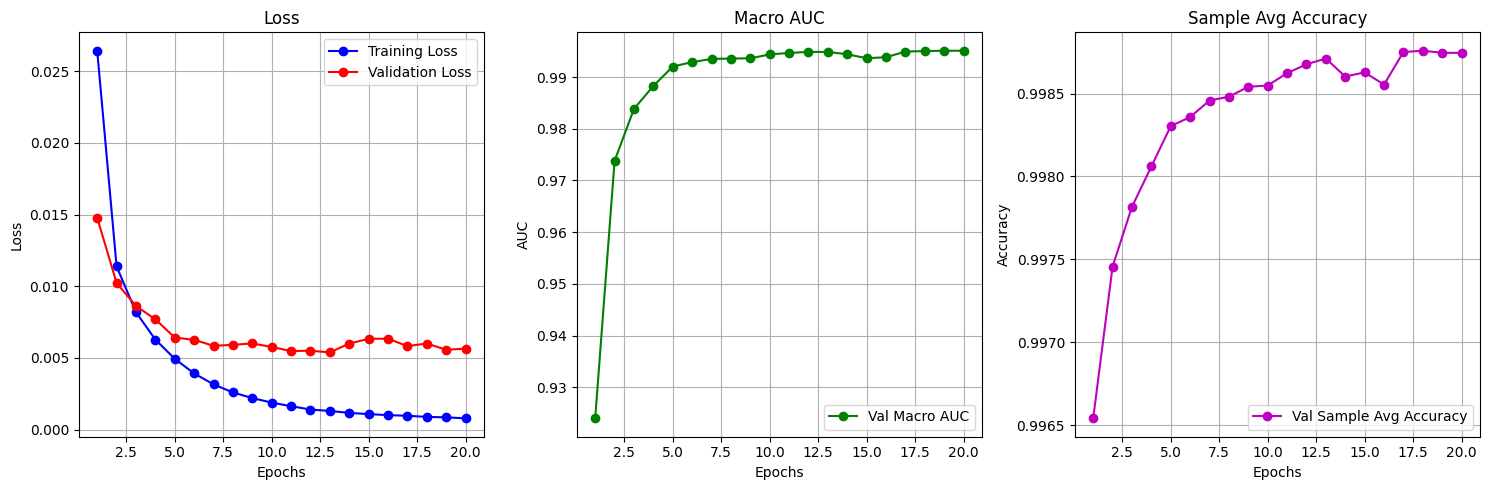

In [32]:
print(f"\nStarting training: {cfg.EPOCHS} epochs, BS={cfg.BATCH_SIZE}, Workers={cfg.NUM_WORKERS}")

if 'dataloaders' in globals() and dataloaders is not None:
  trained_model, training_history = run_training_pipeline(
      model,
      dataloaders,
      loss_func,
      optimizer,
      scaler,
      cfg.EPOCHS,
      device
  )
else:
  print("Error: Dataloaders not initialized, re-run the pipeline.")

# --- Plot Results ---
if 'training_history' in globals():
    epochs_range = range(1, len(training_history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, training_history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs_range, training_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, training_history['val_macro_auc'], 'go-', label='Val Macro AUC')
    plt.title('Macro AUC'); plt.xlabel('Epochs'); plt.ylabel('AUC'); plt.legend(); plt.grid(True)
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, training_history['val_sample_avg_accuracy'], 'mo-', label='Val Sample Avg Accuracy')
    plt.title('Sample Avg Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()